# <b> CART (Classification and Regression Tree)</b>

## 1. Khái niệm

- Thuật toán CART (Cây phân loại và hồi quy) là một biến thể của thuật toán Decision tree. Được dùng trong machine learning và nó giải thích cách mà một biến có thể được dự đoán dựa vào các biến khác.
- Nó có thể xử lý cả phân loại và hồi quy, khác với thuật toán ID3 và C4.5 chỉ có thể cho ra output là biến phân loại nhị phân (CART có thể phân loại nhiều hơn là 2 )
- Điểm khác biệt nữa là CART sử dụng loss function (hàm mất mát) khác với các thuật toán ID3, C4.5. Cụ thể là gini index để chọn điểm chia.


## 2. Cách để tạo DT theo mô hình CART

- Bản chất model của thuật toán CART là một cây nhị phân (gồm root, node con, node lá, ....)
- Cũng như các loại decision tree khác, có 2 loại node chính ở trong model CART:
    - Decision node:
        - Gồm 2 nhánh trái phải trỏ đến địa chỉ của các node con left và right
        - Gồm biến thuộc tính (feature) và ngưỡng chia giá trị của thuộc tính đó. Sự kết hợp của 2 dữ liệu này tạo thành điều kiện của decision node
    - Leaf node: chứa giá trị dự đoán.

- Điều kiện dừng: điều kiện cần thiết để tránh overfitting
    - min sample split : Quy ước số lượng quan sát cần thiết để có thể tách node, nếu số lượng quan sát ko thỏa mãn thì ko tách node nữa
    - max depth: Quy ước độ sâu tối đa cây có thể đạt được.


- Tree pruning: Tỉa cây, khi cây bị overfitting

Dưới đây là code cho cây phân loại:

#### Node class

In [3]:
class Node():
    def __init__(self, feature_index = None, threshold = None, left = None, right = None, information_gain = None, value = None):
        # decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.information_gain = information_gain
        
        #leaf node
        self.value = value     


#### Classifier Decision Tree Class

In [2]:
class DecisionTreeClassifier():
    def __init__(self, min_sample_splits = 2, max_depth = 2):
        #Khởi tạo root
        self.root = None
        
        #Điều kiện dừng của cây
        self.min_sample_splits = min_sample_splits 
        self.max_depth = max_depth
    
    
    def fit(self, X, Y):
        # train cây
        dataset = np.concatenate((X, Y), axis = 1)
        self.root = self.build_tree(dataset)
        
        
    def calculate_info_gain(self, parent, left_child, right_child, mode = "entropy"):
        
        #Trọng số (weight): mối liên hệ giữa số quan sát của tập con với tập cha
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)
        
        if (mode == "gini"):
            gini_index_left = self.gini_index(left_child)
            gini_index_right = self.gini_index(right_child)
            gini_index_parent = self.gini_index(parent)
            
            gain = gini_index_parent - (weight_left * gini_index_left + weight_right * gini_index_right)
        else:
            entropy_parent = self.entropy(parent)
            entropy_left = self.entropy(left_child)
            entropy_right = self.entropy(right_child)
            
            gain = entropy_parent - (weight_left * entropy_left + weight_right * entropy_right)
            
        return gain
    
    
    def entropy(self, y):
        data_labels = np.unique(y) # Lấy ra các giá trị ko trùng lặp của data (1, 1, 1, 0) => (1, 0)
        entropy = 0
        
        for label in data_labels:
            p_label = len(y[y == label]) / len(y) # Xác suất xuất hiện y = label trong tập y (1, 1, 1, 0) => p_1 = 3/4
            entropy += ( - p_label * np.log2(p_label) )
        
        return entropy
    
    def gini_index(self, y): # Tương tự như hàm entropy
        data_labels = np.unique(y)
        gini = 0
        
        for label in data_labels:
            p_label = len(y[y == label]) / len(y)
            gini += p_label**2
        
        return 1 - gini
    
    
    def build_tree(self, dataset, current_depth = 0):
        # Tách biến thuộc tính và mục tiêu làm 2 biến X, Y
        X = dataset[ : , : -1] # Chọn tất cả các hàng và cột trừ cột cuối cùng (Ko có cột type)
        Y = dataset[ : , -1] # Chọn tất cả hàng nhưng chỉ lấy cột cuối cùng (Cột type)
        
        # Lấy ra số lượng quan sát và số biến thuộc tính (Sử dụng np.shape(data))
        num_samples, num_features = np.shape(X) # np.shape(X) trả về số hàng và cột của X 
        
        # Tiếp tục tách cây nếu như thỏa mãn điều kiện dưới
        if (num_samples >= self.min_sample_splits and current_depth <= self.max_depth):
            
            #Tìm ra cách tách tốt nhất
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            #Kiểm tra xem information gain có lớn hơn 0 hay ko (= 0 thì node đó sẽ chứa cùng 1 kiểu dữ liệu => leaf node)
            if (best_split["information_gain"] > 0):
                
                left_tree = self.build_tree(best_split["dataset_left"], current_depth + 1)
                right_tree = self.build_tree(best_split["dataset_right"], current_depth + 1)
                
                #Trả về decision node
                return Node(best_split["feature_index"], best_split["threshold"], left_tree, right_tree, best_split["information_gain"])
            
        # Gặp điều kiện dừng => Node sẽ trở thành leaf node
        
        ## Tính toán giá trị leaf node
        leaf_value = self.calculate_leaf_value(Y)

        # Trả về leaf node 
        return Node(value = leaf_value)
    
    
    def get_best_split(self, dataset, num_samples, num_features):
        # Tạo ra một dictionary để lưu giá trị
        best_split = {} 
        
        # Khởi tạo max information gain
        max_information_gain = -1 
        
        # Duyệt hết các biến thuộc tính (feature)
        for feature_index in range(num_features):
            feature_values = dataset[ : , feature_index] # Lấy ra tất cả các hàng ở cột thứ feature_index
            # => thu được một mảng các giá trị của biến feature thứ index
            
            #Coi mỗi giá trị của biến feature là một threshold (ngưỡng giá trị) để chia dữ liệu
            unique_thresholds = np.unique(feature_values) # Loại bỏ các giá trị trùng lặp
            
            #Duyệt tất cả các giá trị của feature (thresholds) có trong data
            for threshold in unique_thresholds:
                #Tách dataset thành 2 phần tại giá trị threshold
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                #Kiểm tra xem 2 bộ dataset vừa tách ra có null hay không
                if (len(dataset_left) > 0 and len(dataset_right) > 0):
                    
                    # Lấy ra các biến mục tiêu theo 3 bộ data lần lượt
                    y = dataset[ : , -1] #biến mục tiêu gốc
                    left_y = dataset_left[ : , -1] #biến mục tiêu dataset_left
                    right_y = dataset_right[ : , -1] #biến mục tiêu dataset_right
                    
                    #Tính toán information gain
                    current_information_gain = self.calculate_info_gain(y, left_y, right_y, "gini")
                    
                    #update best split nếu thỏa mãn điều kiện dưới
                    if (current_information_gain > max_information_gain):
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["information_gain"] = current_information_gain
                        
                        #update max information gain
                        max_information_gain = current_information_gain
                
        return best_split
    
    
    def split(self, dataset, feature_index, threshold):
        
        rows_left = []
        rows_right = []
        
        # Tách dataset của biến feature thứ index thành 2 phần dựa theo threshold
        for row in dataset:
            if (row[feature_index] <= threshold):
                rows_left.append(row)
            else:
                rows_right.append(row)
        
        #convert từ array sang np.array
        dataset_left = np.array(rows_left)
        dataset_right = np.array(rows_right)
        
        return dataset_left, dataset_right
    
    
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key = Y.count)
                
    
    def print_preorder_tree(self, tree = None, indent = "   "):
        if (not tree):
            tree = self.root
        
        if (tree.value is not None):
            print(tree.value)
        else:
            print("X_" + str(tree.feature_index), "<=", tree.threshold,"?", tree.information_gain)
            print("%sleft: " %(indent), end = "")
            self.print_preorder_tree(tree.left, indent + indent)
            print("%sright: " %(indent), end = "")
            self.print_preorder_tree(tree.right, indent + indent)
            
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    
    def make_prediction(self, x, tree):
        
        if (tree.value != None):
            return tree.value
        
        feature_value = x[tree.feature_index]
        if (feature_value <= tree.threshold):
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

- Để implement decision tree (ở đây là classifier), ta tạo ra 2 class **Node** và **DecisionTreeClassifier**
- **Node** có một hàm dựng với các thuộc tính: 
    - feature_index: index của thuộc tính trong mảng
    - threshold: ngưỡng giá trị của thuộc tính
    - left, right: các node con trái và phải
    - information_gain: gini gain (vì class này hỗ trợ cả tính bằng entropy như id3 nên đặt là information gain để tổng quát)
    
    - value: giá trị của leaf node 
    
- **DecisionTreeClassifier**:
    - Hàm dựng:
        - root: khởi tạo bằng null
        - 2 điều kiện dừng:
            - min_sample_split: số quan sát tối thiểu để node được phép tách tiếp, nếu số quan sát của node < giá trị này thì node này sẽ ko được tách mà sẽ được coi là leaf node
            - max_depth: độ sâu tối thiểu của cây, nếu vượt quá thì sẽ ko được tách tiếp
    - build_tree(dataset, current_depth): Node : Hàm đệ quy để tạo ra cây
    - get_best_split(dataset, num_features, num_samples): Dict : Hàm để tính toán cách tách tốt nhất dựa vào gini gain hoặc info gain
    - gini_index(y): float : tính gini index của tập y
    - entropy(y): float : tính entropy của tập y
    - calculate_info_gain(parent, left_child, right_child, mode): float : tính gini gain (hoặc info gain) tùy vào mode truyền vào
    - predict(X): float : trả về kết quả dự đoán khi model nhận vào một dãy các giá trị X
    - ........

## 3. Quy trình hoạt động

- **B1: Ứng với mỗi node, ta tìm được một điểm chia tốt nhất. Để tìm được điểm chia này ta có thể dùng greedy algorithm (Lặp lại quy trình với mọi dữ liệu đến khi nào lấy ra được dữ liệu tốt nhất chúng ta cần)**
- **B2: Tách dữ liệu input bằng điểm chia tốt nhất đã tìm được ở B1**
- **B3: Tiếp tục lặp lại các bước trên cho đến khi gặp điều kiện dừng của cây hoặc không còn dữ liệu nào chưa được phân loại nữa** 

## 4. Gini gain / impurity

- Thuật toán CART sử dụng gini impurity (Độ tinh khiết) để tách dữ liệu vào trong DT. Điều này được thực hiện bằng cách tìm ra những node con có tập dữ liệu đồng nhất tốt nhất dựa trên tiêu chuẩn gini index.
- gini gain cũng giống như information gain, đều dùng để quyết định xem việc phân chia ở decision node có tốt hay không. Lúc tách node chúng ta sẽ muốn chỉ số gini index càng nhỏ càng tốt

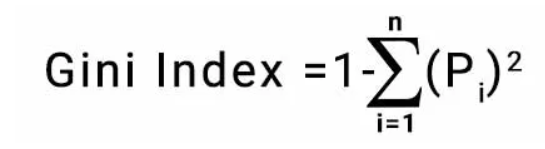

- Sau khi tính được gini index ở node cha và node con, ta có thể tính được chỉ số gini gain:

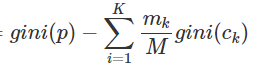

- mk / M chính là trọng số (weight)

- Chúng ta mong muốn chỉ số gini gain này càng lớn càng tốt (tương tự với information gain)

## 5. Classification tree (cây phân loại):
- Đây là thuật toán được sử dụng khi biến mục tiêu là biến phân loại. Thuật toán này dùng để nhận diện lớp nào mà dữ liệu được dự đoán sẽ thuộc về
- Ví dụ cho cây phân loại đã được code ở trên

## 6. Regression tree (cây hồi quy):
- Thuật toán cây hồi quy được dùng khi biến mục tiêu là biến liên tục, cây được sử dụng để dự đoán giá trị mà biến mục tiêu sẽ rơi vào

In [4]:
class Node():
    def __init__(self, feature_index = None,  threshold = None, left = None, right = None, var_reduction = None, value = None ):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_reduction
        self.value = value

In [5]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        ''' function to compute variance reduction '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

- Thay vì sử dụng gini gain thì đối với cây hồi quy, chúng ta sử dụng variance reduciton ( độ giảm phương sai) để quyết định xem điều kiện của decision node có tốt hay không. Tương tự như gini gain, chúng ta muốn chỉ số này càng lớn càng tốt.

## 7. Ưu nhược của CART:

### Ưu điểm: 
- kết quả thường đơn giản, dễ nhìn
- Ko cần chuẩn bị, chuẩn hóa data (Xóa đi những dữ liệu null, ....)
- Có thể xử lý cả biến phân loại và liên tục
- CART model là phi tham số và phi tuyến tính
### Nhược điểm:
- Dễ bị overfitting neu ko preprune
- Phương sai cao
- Cấu trúc của cây có thể ko ổn định